In [1]:
%load_ext load_style
%load_style talk.css

# k-means clustering of SST anomalies in the Pacific with scikit-learn

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

In [3]:
import os
import numpy as np
import pandas as pd
from mpl_toolkits.basemap import Basemap as bm

In [4]:
import xray

### defines a function to plot a field (must be 2D)

In [5]:
def plot_field(X, lat, lon, vmin, vmax, step, cmap=plt.get_cmap('jet'), ax=False, title=False, grid=False):
    if not ax: 
        f, ax = plt.subplots(figsize=(10, (X.shape[0] / float(X.shape[1])) * 10))
    m.ax = ax
    im = m.contourf(lons, lats, X, np.arange(vmin, vmax+step, step), latlon=True, cmap=cmap, extend='both', ax=ax)
    m.drawcoastlines()
    if grid: 
        m.drawmeridians(np.arange(0, 360, 60), labels=[0,0,0,1])
        m.drawparallels([-40, 0, 40], labels=[1,0,0,0])
    m.colorbar(im)
    if title: 
        ax.set_title(title)

### reads the PCs (obtained before, see [sklearn_EOF_decomposition.ipynb](./sklearn_EOF_decomposition.ipynb))

In [6]:
PCs = pd.read_csv('../data/EOF_ERSST_PCs.csv', index_col=0, parse_dates=True)

In [7]:
PCs.head()

,EOF1,EOF2,EOF3,EOF4,EOF5,EOF6,EOF7,EOF8,EOF9
time,,,,,,,,,
1980-01-15,-1.212233,-0.494918,0.972392,0.281485,-0.203608,2.072378,-0.632693,1.473872,-1.271845
1980-02-15,-1.213163,-0.715776,1.258066,0.741005,0.068926,2.731611,-0.182779,2.636705,-1.737925
1980-03-15,-0.898226,-0.562729,0.855915,1.316607,0.514087,2.650314,-0.001962,1.904691,-0.073639
1980-04-15,-1.037391,-1.086395,0.485100,0.374338,0.952949,1.320651,-0.340679,1.921813,0.549309
1980-05-15,-1.010956,-1.156914,0.006662,0.309884,0.534675,0.655073,-0.508158,1.677837,-0.253518


### import the KMeans class from scikit-learn

In [8]:
from sklearn.cluster import KMeans

#### How many clusters do we want ? 

In [11]:
nclusters = 6

#### instantiates the k-means class

In [39]:
KMeans?

In [40]:
kmeans = KMeans(init='random', n_clusters=nclusters, n_init=10)

#### fit to the data

In [15]:
X = PCs.values

In [16]:
type(X)

numpy.ndarray

In [41]:
kmeans.fit(X) 

KMeans(copy_x=True, init='random', max_iter=300, n_clusters=6, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

#### the classes (clusters) are contained in the .labels_ attributes

In [42]:
kmeans.labels_

array([1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4,
       4, 4, 4, 3, 3, 1, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 5, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1,
       1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0,

### Calculate composite anomalies for each of the clusters

In [20]:
ncfname = '../data/ersst.realtime.nc'

In [21]:
dset = xray.open_dataset(ncfname)

In [22]:
dsub = dset.sel(time=slice('1980','2014'),lat=slice(-40,40), lon=slice(120,290))

In [23]:
dsub

<xray.Dataset>
Dimensions:  (lat: 41, lon: 86, time: 420, zlev: 1)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-15 1980-02-15 1980-03-15 1980-04-15 1980-05-15 ...
  * zlev     (zlev) float32 0.0
  * lat      (lat) float32 -40.0 -38.0 -36.0 -34.0 -32.0 -30.0 -28.0 -26.0 -24.0 -22.0 -20.0 ...
  * lon      (lon) float32 120.0 122.0 124.0 126.0 128.0 130.0 132.0 134.0 136.0 138.0 140.0 ...
Data variables:
    sst      (time, zlev, lat, lon) float64 15.19 15.12 15.04 15.04 15.1 15.12 15.08 15.09 15.18 ...
    anom     (time, zlev, lat, lon) float64 -0.13 -0.18 -0.24 -0.27 -0.25 -0.29 -0.4 -0.5 -0.56 ...
    err      (time, zlev, lat, lon) float64 0.46 0.42 0.38 0.35 0.37 0.36 0.32 0.31 0.27 0.27 ...
Attributes:
    title: ERSST V3b in situ only
    history: Wed Apr  8 09:45:04 2015: /usr/local/bin/ncrcat -O ersst.194802_ft.nc ersst.194803_ft.nc ersst.194804_ft.nc ersst.194805_ft.nc ersst.194806_ft.nc ersst.194807_ft.nc ersst.194808_ft.nc ersst.194809_ft.nc ersst.194810_ft.nc erss

In [24]:
lat = dsub['lat'].values
lon = dsub['lon'].values
lons, lats = np.meshgrid(lon, lat)

In [44]:
labels = pd.DataFrame(kmeans.labels_, index=dsub['time'], columns=['cluster'])

In [45]:
labels.head()

,cluster
time,
1980-01-15,1
1980-02-15,1
1980-03-15,1
1980-04-15,1
1980-05-15,1


In [27]:
pd.unique(labels.cluster)

array([4, 5, 0, 1, 3, 2])

In [29]:
c = 0

In [32]:
clussub = labels.query('cluster == {}'.format(c))

In [34]:
clussub.index

<class 'pandas.tseries.index.DatetimeIndex'>
[1981-01-15, ..., 1996-11-15]
Length: 86, Freq: None, Timezone: None

In [35]:
cluster = dsub.sel(time=clussub.index).mean('time')

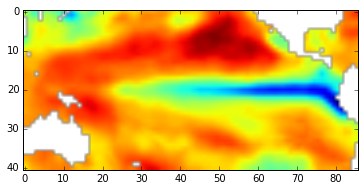

In [36]:
plt.imshow(cluster['anom'][0,::-1,:])

In [37]:
m = bm(projection='cyl',llcrnrlat=-40,urcrnrlat=40,\
            llcrnrlon=120,urcrnrlon=290,\
            lat_ts=0,resolution='c')

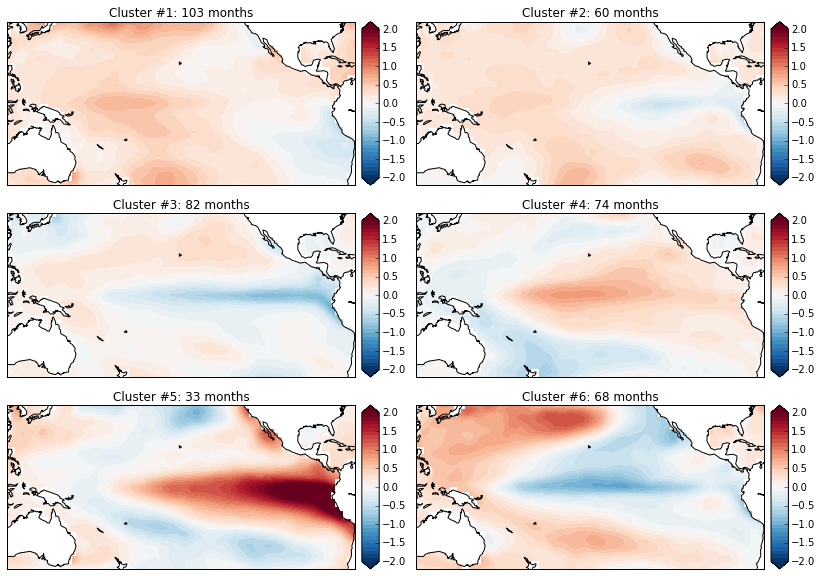

In [46]:
f, axes = plt.subplots(nrows=3,ncols=2, figsize=(14,10))
f.subplots_adjust(hspace=0.1, wspace=0.1)
axes = axes.flatten()
for c in xrange(nclusters):
    index = labels.query('cluster == {}'.format(c))
    cluster = dsub.sel(time=index.index).mean('time')
    ax = axes[c]
    plot_field(cluster['anom'][0,:,:], lats, lons, -2, 2, 0.1, \
               ax=ax, cmap=plt.get_cmap('RdBu_r'), \
               title="Cluster #{}: {} months".format(c+1, len(index)))

In [49]:
kmeans.cluster_centers_.shape

(6, 9)

In [53]:
kmeans.inertia_

2576.3147022801477